# Setup

In [1]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-03-11.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = "consultation-documents-features-2025-03-18.parquet"

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    # ("RESPONSE_FORM", "SURVEY"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    # "FINAL_REPORT",  # might not work well
    # "RESPONSE_FORM",  # might not work well
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.utils.multiclass
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier  # noqa: F401
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # noqa: F401
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from research.document_types import data_loading, document_title_rule_model
from research.lib import data_access, embeddings, plotting, utils

In [4]:
dotenv.load_dotenv()

True

In [5]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
;

Starting run: ambitious-cat-58


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/03/18 16:51:25 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

In [8]:
df_input, df_test_external = data_loading.load_documents(
    document_file=PREPROCESSED_DATA_FILE,
    external_test_labels_file=REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx",
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    include_rule_labels=INCLUDE_RULE_LABELS_IN_TRAINING,
    class_merges=MERGE_CLASSES,
)

print("df_input labels:")
df_input.groupby("document_type_label_source")["document_type"].value_counts()

df_input labels:


document_type_label_source  document_type 
explicit                    LETTER            3148
                            DRAFT             2953
                            REPORT            2196
                            RECIPIENT_LIST    1804
                            FINAL_REPORT      1769
                            OPINION           1004
                            VARIOUS_TEXT       463
                            SYNOPTIC_TABLE     115
                            SURVEY              19
                            RESPONSE_FORM        7
                            DECISION             0
                            LINK                 0
rule                        LETTER            1536
                            SYNOPTIC_TABLE     690
                            RECIPIENT_LIST     611
                            DECISION             0
                            DRAFT                0
                            FINAL_REPORT         0
                            LINK       

In [9]:
df_test_external

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain,document_type_label_source,document_type
38521,38522,2317,2021-09-08,2021-12-09,Materielle und formelle Revision des Gebührenr...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/xnyvgkgk,"[economics, finance]",de,"Beilage 1 zum Anhörungsbericht (PDF, 84 Seiten...",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Synopse Beilage 1 zum Anhörungsbericht \n \nA...,external_test,SYNOPTIC_TABLE
38570,38571,2322,2022-02-20,2022-04-21,Anpassung des Richtplans; Verminderung der Fru...,,https://www.ag.ch/media/kanton-aargau/bvu/raum...,https://www.demokratis.ch/vernehmlassung/84ssk4vc,"[energy, environment, spatial_planning]",de,"Planungsbericht (PDF, 31 Seiten, 2,7 MB)",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Axpo Power AG | Hydroenergie & Biomasse \n\nPa...,external_test,VARIOUS_TEXT
38660,38684,2339,2012-01-06,2012-02-06,Gemeinde Gontenschwil; Anpassung des Richtplans,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/fs257a7u,[spatial_planning],de,"Information (PDF, 8 Seiten, 450 KB)",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,j:\vernehmlassungen\vernehmlassungen\kanton\rp...,external_test,REPORT
38664,38688,2340,2012-01-11,2012-04-13,eHealth; IDAG und des Gesundheitsgesetz; Teilr...,Der Bund wird voraussichtlich im Jahr 2015 ode...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/69q4yzws,"[health, it]",de,"Schreiben der Vorsteherin (PDF, 2 Seiten, 32 KB)",141,Regierungsrat des Kantons Aargau,ag,2025-01-25 14:10:50,openparldata,manual,Departement \nGesundheit und Soziales \nVorste...,external_test,LETTER
38747,38771,2362,2012-12-10,2013-03-08,Gemeinde Würenlos; Anpassung des Richtplans,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/nnuj5gx8,[spatial_planning],de,"Anpassung allgemeine Nutzungsplanung (PDF, 52 ...",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Gemeinde Würenlos Kanton Aargau \n___________...,external_test,REPORT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50583,52074,4835,2024-08-16,2024-11-11,Änderung des Finanzausgleichsgesetzes,"Der Regierungsrat hat in Aussicht gestellt, na...",https://sh.ch/CMS/get/file/f6cad1a9-895e-40d7-...,https://www.demokratis.ch/vernehmlassung/vwp33sb5,"[administration, public_finance, security]",de,"Präsentation, FAG STG, 16.8.2024",157,Regierungsrat des Kantons Schaffhausen,sh,2024-10-17 15:54:23,openparldata,manual,Kanton Schaffhausen\nMedienkonferenz\nÄnderung...,external_test,VARIOUS_TEXT
50915,52424,4886,2024-09-13,2024-10-15,Änderung der Verordnung zum Einführungsgesetz ...,"Der Regierungsrat plant, die monatlichen Kinde...",https://zg.ch/dam/jcr:95397bc7-9729-4e66-9c3c-...,https://www.demokratis.ch/vernehmlassung/nmu3kfpv,"[economics, public_finance, social]",de,3) Antwortformular,165,Regierungsrat des Kantons Zug,zg,NaT,openparldata,openparldata,Amt für Gesundheit_3 \n \nÄnderung der Verord...,external_test,RESPONSE_FORM
51036,52559,4901,2024-09-19,2024-10-31,Revision des Gesetzes über den Fristenlauf (FriG),Der Bund nimmt auf Anfang 2025 eine Änderung b...,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/w4rqwc8a,"[administration, communications, law]",de,Begleitschreiben zur Revision des Gesetzes übe...,142,Standeskommission Appenzell Innerrhoden,ai,2024-10-16 10:51:54,openparldata,manual,AI 013.25-27.71.5-1211726 1-2 \nLandammann un...,external_test,LETTER
51410,52971,4943,2024-10

In [10]:
# # Test: remove documents known to have label issues
# document_ids_with_issues = pd.read_csv("cleanlab_1_document_ids.csv")
# df_input = df_input[~df_input["document_id"].isin(document_ids_with_issues["document_id"])]

In [11]:
df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            4684
DRAFT             2953
RECIPIENT_LIST    2415
REPORT            2196
FINAL_REPORT      1769
OPINION           1004
SYNOPTIC_TABLE     805
VARIOUS_TEXT       463
SURVEY              19
RESPONSE_FORM        7
DECISION             0
LINK                 0
Name: count, dtype: int64

## Drop empty documents

In [12]:
def drop_empty_texts(df: pd.DataFrame) -> pd.DataFrame:
    empty_index = df["document_content_plain"].str.strip() == ""
    empty_count = len(df[empty_index])
    print(f"Empty texts: {empty_count} ({100 * empty_count / len(df):.1f}%)")
    return df.loc[~empty_index]


print("df_input:", end=" ")
df_input = drop_empty_texts(df_input)
print("df_test_external:", end=" ")
df_test_external = drop_empty_texts(df_test_external)

df_input: Empty texts: 1015 (6.2%)
df_test_external: Empty texts: 7 (5.6%)


## Data representation

<Axes: xlabel='document_type'>

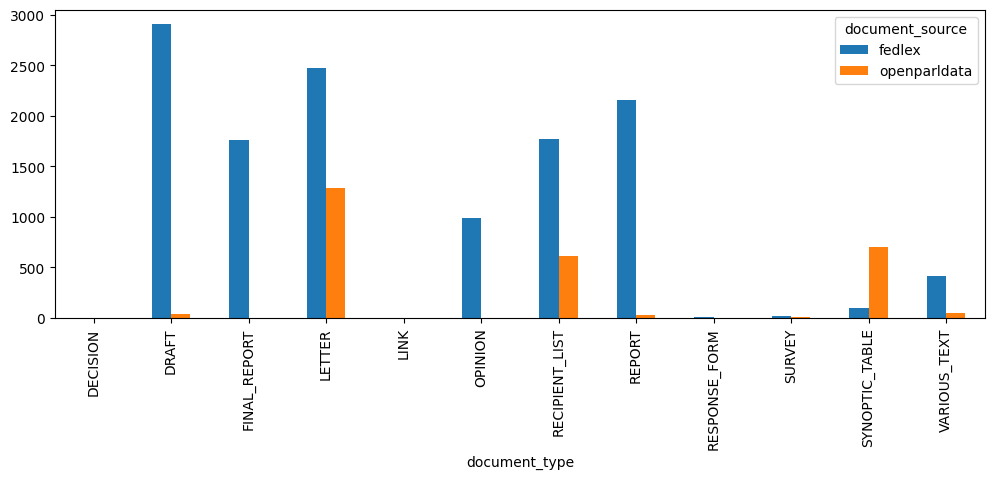

In [13]:
df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
).plot(kind="bar", figsize=(12, 4))

## Additional features

In [14]:
FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,contains_table_on_first_page,count_pages,count_tables,count_images,count_pages_containing_tables,count_pages_containing_images,average_page_aspect_ratio
document_id,,,,,,,
1,False,26,0.0,0.0,0.0,0.0,0.704898
2,False,26,0.0,0.0,0.0,0.0,0.704898
3,False,25,0.0,0.0,0.0,0.0,0.704898
4,False,6,0.0,1.0,0.0,1.0,0.707098
5,False,6,0.0,1.0,0.0,1.0,0.707098
...,...,...,...,...,...,...,...
54314,False,5,0.0,2.0,0.0,1.0,0.707108
54315,False,5,0.0,1.0,0.0,1.0,0.706651
54319,False,3,2.0,0.0,2.0,0.0,1.414210


In [15]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    previous_shape = df.shape
    df = df.join(df_features, on="document_id", how="inner")
    df["fraction_pages_containing_tables"] = df["count_pages_containing_tables"] / df["count_pages"]
    df["fraction_pages_containing_images"] = df["count_pages_containing_images"] / df["count_pages"]
    df["contains_synopse_keyword"] = (
        df["document_content_plain"].str.slice(0, 1000).str.contains("synopse", case=False, regex=False)
    )
    df["contains_salutation"] = (
        df["document_content_plain"]
        .str.slice(0, 3000)
        .str.contains(
            r"(?:Sehr\s+geehrte[r]?\s+(?:Frau|Herr|Damen\s+und\s+Herren)|"
            r"Liebe[r]?\s+(?:Frau|Herr|Damen\s+und\s+Herren)|"
            r"Sehr\s+geehrte[r]?\s+(?:"
            r"Bundesr(?:at|ätin)|"
            r"Regierungsr(?:at|ätin)|"
            r"Nationalr(?:at|ätin)|"
            r"Stadtpr[äa]sid(?:ent|entin)|"
            r"Gemeindepr[äa]sid(?:ent|entin)|"
            r"Stadtr(?:at|ätin)|"
            r"Gemeinder(?:at|ätin)|"
            r"Pr[äa]sid(?:ent|entin)))",
            case=False,
            regex=True,
        )
    )
    print(
        f"{previous_shape[0] - df.shape[0]} rows were lost due to missing features. Remaining rows: {df.shape[0]}. "
        f"{df.shape[1] - previous_shape[1]} columns were added."
    )
    return df

In [16]:
df_input = add_features(df_input)
df_test_external = add_features(df_test_external)

777 rows were lost due to missing features. Remaining rows: 14523. 11 columns were added.
13 rows were lost due to missing features. Remaining rows: 106. 11 columns were added.


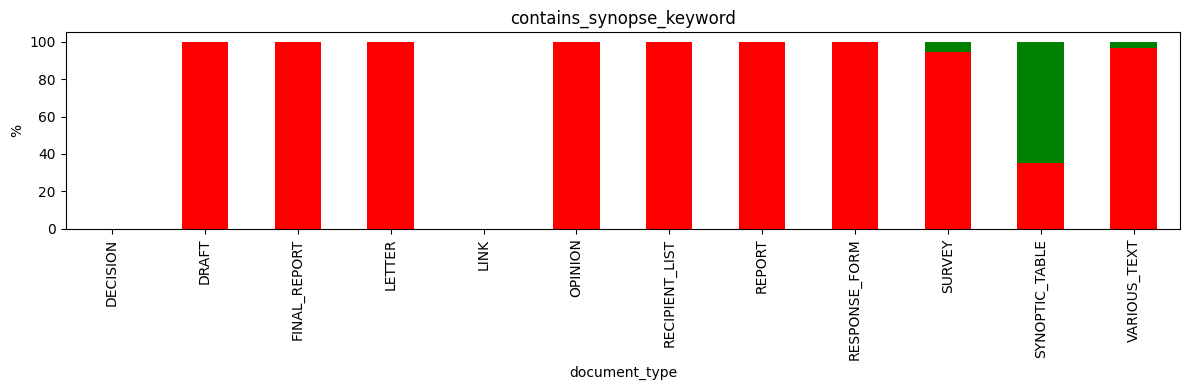

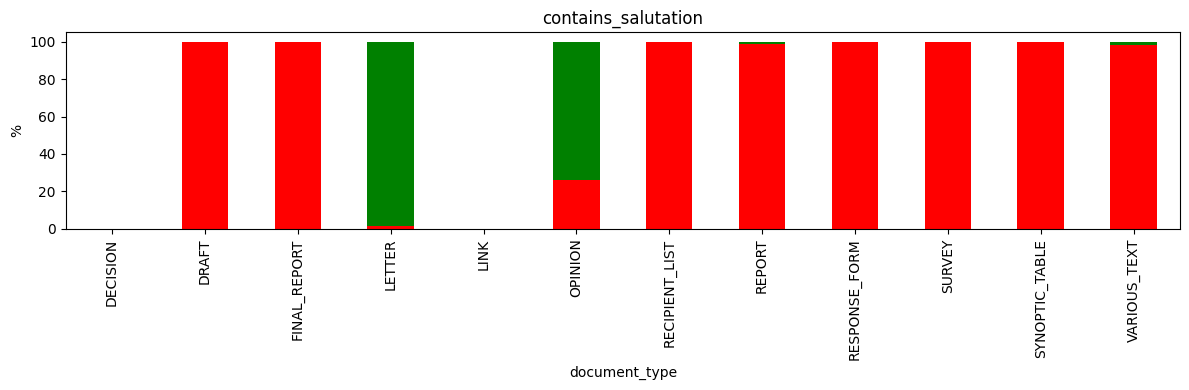

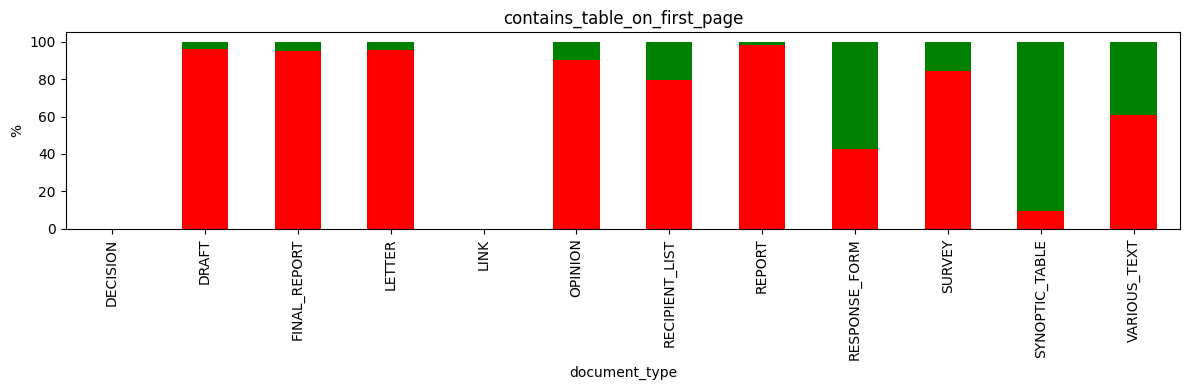

In [17]:
def plot_feature_across_document_types(df: pd.DataFrame, feature_name: str) -> None:
    counts = df.groupby("document_type", observed=False)[feature_name].value_counts(normalize=True) * 100
    pivot_table = counts.reset_index(name="percentage").pivot_table(
        index="document_type", columns=feature_name, values="percentage", aggfunc="sum", observed=False
    )
    pivot_table.plot(
        kind="bar",
        stacked=True,
        color=["r", "g"],
        figsize=(12, 4),
        legend=False,
        title=feature_name,
        ylabel="%",
    )
    plt.tight_layout()
    plt.show()


plot_feature_across_document_types(df_input, "contains_synopse_keyword")
plot_feature_across_document_types(df_input, "contains_salutation")
plot_feature_across_document_types(df_input, "contains_table_on_first_page")

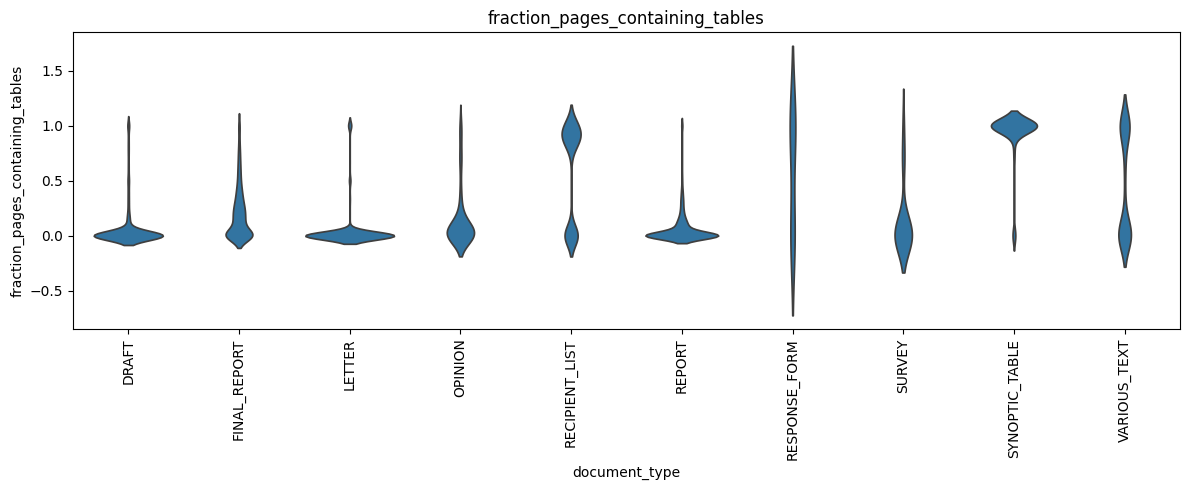

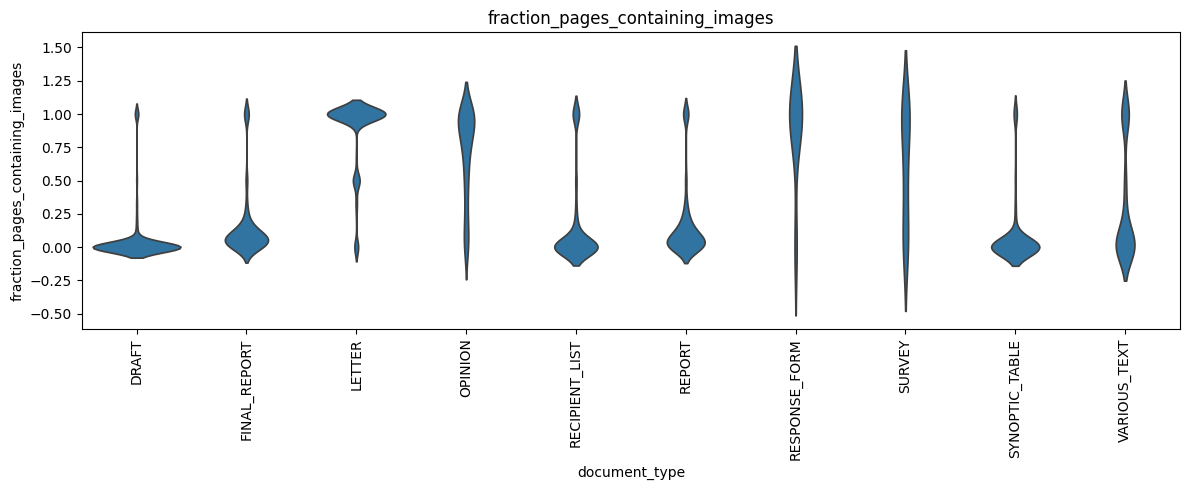

In [18]:
def plot_feature_distribution_across_document_types(df: pd.DataFrame, feature_name: str) -> None:
    plt.figure(figsize=(12, 5))

    sns.violinplot(
        data=df,
        x="document_type",
        order=sorted(df["document_type"].unique()),
        y=feature_name,
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
    )
    plt.xticks(rotation=90)
    plt.title(feature_name)
    plt.tight_layout()
    plt.show()


plot_feature_distribution_across_document_types(df_input, "fraction_pages_containing_tables")
plot_feature_distribution_across_document_types(df_input, "fraction_pages_containing_images")

## Splits

### Set aside a test set

In [19]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type"]))

In [20]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (13070, 31)
Test: (1453, 31)


In [21]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

1453

### Prepare a cross-validation splitter

In [22]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [23]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test_external = df_test_external["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 106/106 [00:00<00:00, 329.15it/s]


## Embed

In [24]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=False,
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)
    embeddings_test_external = get_embeddings(tokens_test_external.tolist())
    print(embeddings_test_external.shape)

Embedding (cached=13069, new=0): 100%|██████████| 13070/13070 [00:09<00:00, 1386.38it/s]


(13070, 3072)


Embedding (cached=1452, new=0): 100%|██████████| 1453/1453 [00:01<00:00, 1266.39it/s]


(1453, 3072)


Embedding (cached=105, new=0): 100%|██████████| 106/106 [00:00<00:00, 1408.51it/s]


(106, 3072)


# Classification

In [25]:
extra_feature_columns = [
    "contains_synopse_keyword",  # bool: whether the beginning of the document contains the word "synopse"
    "contains_salutation",  # bool: whether the beginning of the document contains a formal German letter greetings
    # "contains_table_on_first_page",  # bool: whether the first page contains a table
    "count_pages",  # int: number of pages in the document
    "count_pages_containing_images",  # int: number of pages containing images (for documents <= 50 pages)
    "fraction_pages_containing_images",  # float: count_pages_containing_images / count_pages
    "count_pages_containing_tables",  # int: number of pages containing tables (for documents <= 50 pages)
    "fraction_pages_containing_tables",  # float: count_pages_containing_tables / count_pages
    "average_page_aspect_ratio",  # float: average aspect ratio of pages (width / height) (for documents <= 50 pages)
]
extra_categorical_feature_columns = [
    # "political_body",
    # "document_source",
]

mlflow.log_param("extra_feature_columns", sorted(extra_feature_columns))
mlflow.log_param("extra_categorical_feature_columns", sorted(extra_categorical_feature_columns))


def create_matrices(df: pd.DataFrame, embeddings: np.ndarray) -> tuple[np.ndarray, pd.Series]:
    x = np.hstack(
        (
            embeddings,
            df[extra_feature_columns].fillna(0),
            df[extra_categorical_feature_columns],
        )
    )
    y = df["document_type"]
    assert x.shape[0] == y.shape[0]
    return x, y


X_train, y_train = create_matrices(df_input_train, embeddings_train)
X_test, y_test = create_matrices(df_input_test, embeddings_test)
X_test_external, y_test_external = create_matrices(df_test_external, embeddings_test_external)

print("train", X_train.shape)
print("test", X_test.shape)
print("test_external", X_test_external.shape)

train (13070, 3080)
test (1453, 3080)
test_external (106, 3080)


In [26]:
i_embeddings = 0
i_extra_features = i_embeddings + embeddings_train.shape[1]
i_categorical_features = i_extra_features + len(extra_feature_columns)
assert i_categorical_features + len(extra_categorical_feature_columns) == X_train.shape[1]


def create_classifier() -> Pipeline:
    pca_step = None  # If this is set in the pipeline below, we'll log the number of components to MLflow.
    pipeline = make_pipeline(
        ColumnTransformer(
            [
                (
                    "embeddings",
                    make_pipeline(
                        StandardScaler(),
                        pca_step := PCA(n_components=20, random_state=RANDOM_STATE),
                    ),
                    slice(i_embeddings, i_extra_features),
                ),
                (
                    "extra_features",
                    make_pipeline(
                        StandardScaler(),
                    ),
                    slice(i_extra_features, i_categorical_features),
                ),
                # (
                #     "categorical_features",
                #     make_pipeline(
                #         OneHotEncoder(
                #             sparse_output=False,
                #             categories=[
                #                 # list(schemata.CANTON_CODES | {schemata.FEDERAL_CODE}),
                #                 # ["fedlex", "openparldata"],
                #             ],
                #         ),
                #         StandardScaler(),
                #     ),
                #     slice(i_categorical_features, None),
                # ),
            ]
        ),
        LogisticRegression(max_iter=2000),
        # GradientBoostingClassifier(random_state=RANDOM_STATE),
    )
    if pca_step is not None:
        mlflow.log_param("pca_n_components", pca_step.get_params()["n_components"])
    return pipeline


classifier = create_classifier()
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=20,
                                                                       random_state=2718))]),
                                                  slice(0, 3072, None)),
                                                 ('extra_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3072, 3080, None))])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [27]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        try:
            pca = pipeline.named_steps["columntransformer"].named_transformers_["embeddings"].named_steps["pca"]
        except (KeyError, AttributeError):
            return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'fit_time': array([10.9470768 ,  9.70843387, 13.76575184, 12.79486489, 11.59873295]),
 'score_time': array([0.38632703, 0.36366701, 0.41963601, 0.45725799, 0.42786407]),
 'test_precision': array([0.94003395, 0.93861603, 0.92916233, 0.92931693, 0.92463812]),
 'test_recall': array([0.94338179, 0.9407039 , 0.93458301, 0.93687835, 0.93190513]),
 'test_f1': array([0.94062858, 0.93891381, 0.93073342, 0.93229588, 0.92639888]),
 'test_pca_explained_variance': array([0.41824338, 0.41867032, 0.41820301, 0.41852249, 0.41808794]),
 'test_accuracy': array([0.94338179, 0.9407039 , 0.93458301, 0.93687835, 0.93190513]),
 'test_top_k_accuracy': array([0.97628156, 0.97283856, 0.96710023, 0.97245601, 0.97092578])}

## Evaluation of the cross-validation

In [28]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in scores_docs.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9375,
 'cv_f1': 0.9338,
 'cv_pca_explained_variance': 0.4183,
 'cv_precision': 0.9324,
 'cv_recall': 0.9375,
 'cv_top_k_accuracy': 0.9719}


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [29]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [30]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/03/18 16:54:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/03/18 16:54:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.90      0.95      0.92       263
  FINAL_REPORT       0.97      0.94      0.96       159
        LETTER       1.00      0.99      1.00       313
       OPINION       0.95      0.92      0.94        89
RECIPIENT_LIST       1.00      1.00      1.00       200
        REPORT       0.88      0.93      0.91       195
 RESPONSE_FORM        nan      0.00      0.00         1
        SURVEY       1.00      0.50      0.67         2
SYNOPTIC_TABLE       0.97      0.83      0.89        46
  VARIOUS_TEXT       0.60      0.46      0.52        39

      accuracy                           0.94      1307
     macro avg       0.92      0.75      0.78      1307
  weighted avg       0.94      0.94      0.94      1307



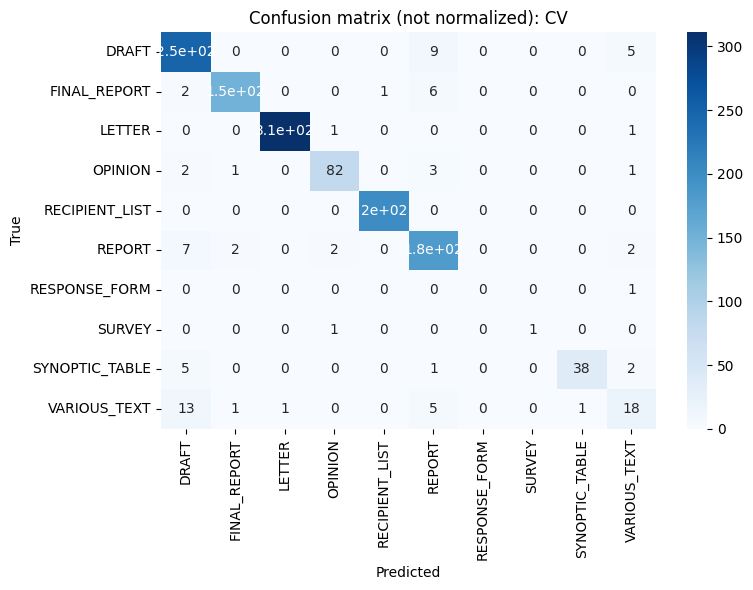

In [31]:
report = sklearn.metrics.classification_report(y_cv_test, cv_test_predictions, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

### Feature importance

In [32]:
# explainer = shap.Explainer(classifier)  # .named_steps["logisticregression"])
# shap_values = explainer(X_cv_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])


# def get_shap_values_for_complex_pipeline(pipeline, X_test):
#     # Extract preprocessing steps
#     column_transformer = pipeline.named_steps["columntransformer"]
#     classifier = pipeline.named_steps["logisticregression"]

#     # Transform a small batch of data for initialization
#     background_indices = np.random.choice(X_test.shape[0], 100, replace=False)
#     background_data = column_transformer.transform(X_test[background_indices])

#     # Create explainer with both model and background data
#     explainer = shap.KernelExplainer(classifier.predict, background_data)

#     # Transform the full test data
#     transformed_data = column_transformer.transform(X_test)

#     # Get SHAP values
#     shap_values = explainer.shap_values(transformed_data)

#     return shap_values


# Usage
# shap_values = get_shap_values_for_complex_pipeline(classifier, X_cv_test)
# shap_values


In [33]:
# importances = pd.Series(
#     classifier.named_steps["gradientboostingclassifier"].feature_importances_,
#     index=[f"embedding_{i:02d}" for i in range(20)] + extra_feature_columns,
# )
# importances.sort_values(ascending=False)

***

## Evaluation on the test set (USE SPARINGLY)

2025/03/18 16:54:27 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/03/18 16:54:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.91      0.98      0.94       293
  FINAL_REPORT       0.94      0.97      0.96       176
        LETTER       0.99      1.00      0.99       348
       OPINION       0.97      0.94      0.95        98
RECIPIENT_LIST       1.00      0.99      1.00       223
        REPORT       0.93      0.94      0.94       217
 RESPONSE_FORM       1.00      1.00      1.00         1
        SURVEY       1.00      0.50      0.67         2
SYNOPTIC_TABLE       0.78      0.84      0.81        51
  VARIOUS_TEXT       0.56      0.20      0.30        44

      accuracy                           0.95      1453
     macro avg       0.91      0.84      0.86      1453
  weighted avg       0.94      0.95      0.94      1453



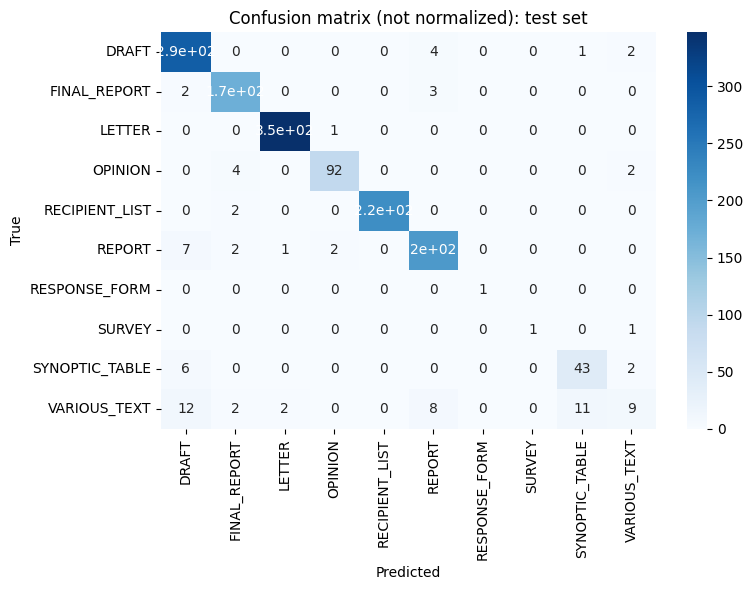

{'test_accuracy': 0.947,
 'test_f1': 0.9409,
 'test_precision': 0.9406,
 'test_recall': 0.947,
 'test_top_k_accuracy': 0.98}


In [34]:
if USE_TEST_SET:
    # Training & OOS predictions
    classifier_test = create_classifier()
    classifier_test.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier_test.predict(X_test)

    # Classification report
    report = sklearn.metrics.classification_report(
        test_ground_truth_docs,
        test_predictions_docs,
        zero_division=np.nan,
    )
    mlflow.log_text(report, "test_classification_report.txt")
    print(report)

    # Confusion matrix
    cm = plotting.plot_confusion_matrix_heatmap(test_ground_truth_docs, test_predictions_docs, title="test set")
    mlflow.log_figure(cm, "test_confusion_matrix.png")
    display(cm)

    # Metrics
    p_r_f1 = sklearn.metrics.precision_recall_fscore_support(
        test_ground_truth_docs,
        test_predictions_docs,
        average="weighted",
        zero_division=np.nan,
    )
    utils.log_metrics(
        test_precision=p_r_f1[0],
        test_recall=p_r_f1[1],
        test_f1=p_r_f1[2],
        test_accuracy=sklearn.metrics.accuracy_score(test_ground_truth_docs, test_predictions_docs),
        test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(
            test_ground_truth_docs, classifier_test.predict_proba(X_test)
        ),
    )

***

# Rule-based & ML model evaluation

## Test both the rule-based model and the sklearn model on the external test set

Use both models to generate predictions:

In [35]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_test_external.copy()
_df.loc[:, "document_type"] = None
df_test_external["prediction_rule"] = data_loading.merge_classes(document_title_rule_model.predict(_df), MERGE_CLASSES)

In [36]:
classifier_external_test = create_classifier()
# classifier_external_test.fit(np.vstack((X_train, X_test)), pd.concat([y_train, y_test], ignore_index=True))
classifier_external_test.fit(X_train, y_train)

df_test_external["prediction_ml"] = classifier_external_test.predict(X_test_external)
df_test_external["prediction_ml_proba"] = classifier_external_test.predict_proba(X_test_external).tolist()

2025/03/18 16:54:53 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/03/18 16:55:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


### Display all samples

In [37]:
df_test_external[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
39623,39759,ai,vnl,doc,Entwurf Verordnung über die Nutzung des Untergrundes (VNU),DRAFT,DRAFT,DRAFT
39624,39760,ai,vnl,doc,Erläuternder Bericht zum Entwurf für ein Gesetz über die Nutzung des Untergrundes (GNU),REPORT,REPORT,REPORT
39706,39842,ai,vnl,doc,Entwurf Landsgemeindebeschluss über die Revision der Gerichtsorganisationsbestimmungen,DRAFT,DRAFT,DRAFT
39752,39888,ar,vnl,doc,Synopse,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39761,39897,ar,vnl,doc,Liste der Vernehmlassungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
39769,39905,ar,vnl,doc,Erläuternder Bericht,REPORT,REPORT,REPORT
39779,39915,ar,vnl,doc,Begleitschreiben Vernehmlassung,LETTER,LETTER,LETTER
39917,40053,ar,vnl,doc,erläuternder Bericht,REPORT,REPORT,REPORT
39927,40063,ar,vnl,doc,Synopse,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39931,40067,ar,vnl,doc,Glossar,VARIOUS_TEXT,nan,VARIOUS_TEXT


In [38]:
# df_test_external.loc[df_test_external["document_id"] == 47461, "document_content_plain"].values[0]

In [39]:
df_test_external["document_type"].value_counts(dropna=False)

document_type
REPORT            29
DRAFT             24
LETTER            13
SYNOPTIC_TABLE    13
VARIOUS_TEXT       8
RECIPIENT_LIST     8
FINAL_REPORT       8
RESPONSE_FORM      2
OPINION            1
DECISION           0
LINK               0
SURVEY             0
Name: count, dtype: int64

### ML model vs. ground truth

In [40]:
external_test_precision, external_test_recall, external_test_f1, _ = sklearn.metrics.precision_recall_fscore_support(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    external_test_accuracy=sklearn.metrics.accuracy_score(
        df_test_external["document_type"], df_test_external["prediction_ml"]
    ),
    external_test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(
        df_test_external["document_type"],
        np.array(df_test_external["prediction_ml_proba"].tolist()),
        labels=sklearn.utils.multiclass.unique_labels(
            df_input_train["document_type"], df_test_external["document_type"]
        ),
    ),
    external_test_precision=external_test_precision,
    external_test_recall=external_test_recall,
    external_test_f1=external_test_f1,
)

{'external_test_accuracy': 0.8113,
 'external_test_f1': 0.8039,
 'external_test_precision': 0.8423,
 'external_test_recall': 0.8113,
 'external_test_top_k_accuracy': 0.8679}


                precision    recall  f1-score   support

         DRAFT       0.84      0.88      0.86        24
  FINAL_REPORT       0.75      0.38      0.50         8
        LETTER       0.87      1.00      0.93        13
       OPINION       0.20      1.00      0.33         1
RECIPIENT_LIST       1.00      1.00      1.00         8
        REPORT       0.91      0.69      0.78        29
 RESPONSE_FORM        nan      0.00      0.00         2
SYNOPTIC_TABLE       0.72      1.00      0.84        13
  VARIOUS_TEXT       0.78      0.88      0.82         8

      accuracy                           0.81       106
     macro avg       0.76      0.76      0.67       106
  weighted avg       0.84      0.81      0.80       106



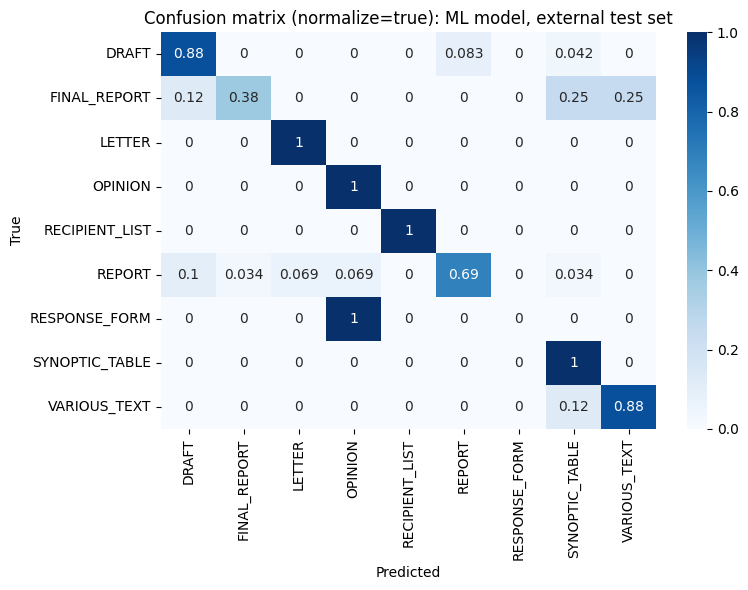

In [41]:
report = sklearn.metrics.classification_report(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    zero_division=np.nan,
)
mlflow.log_text(report, "external_test_classification_report.txt")
print(report)

cm = plotting.plot_confusion_matrix_heatmap(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    title="ML model, external test set",
    normalize="true",
)
mlflow.log_figure(cm, "external_test_confusion_matrix.png")
display(cm)

### Rule-based model vs. ground truth

                precision    recall  f1-score   support

         DRAFT       0.69      0.75      0.72        12
  FINAL_REPORT       1.00      0.33      0.50         6
        LETTER       1.00      1.00      1.00        12
       OPINION        nan      0.00      0.00         1
RECIPIENT_LIST       1.00      0.83      0.91         6
        REPORT       0.94      0.89      0.91        18
 RESPONSE_FORM       1.00      1.00      1.00         1
SYNOPTIC_TABLE       1.00      0.82      0.90        11
  VARIOUS_TEXT       0.20      1.00      0.33         2

      accuracy                           0.81        69
     macro avg       0.85      0.74      0.70        69
  weighted avg       0.91      0.81      0.83        69



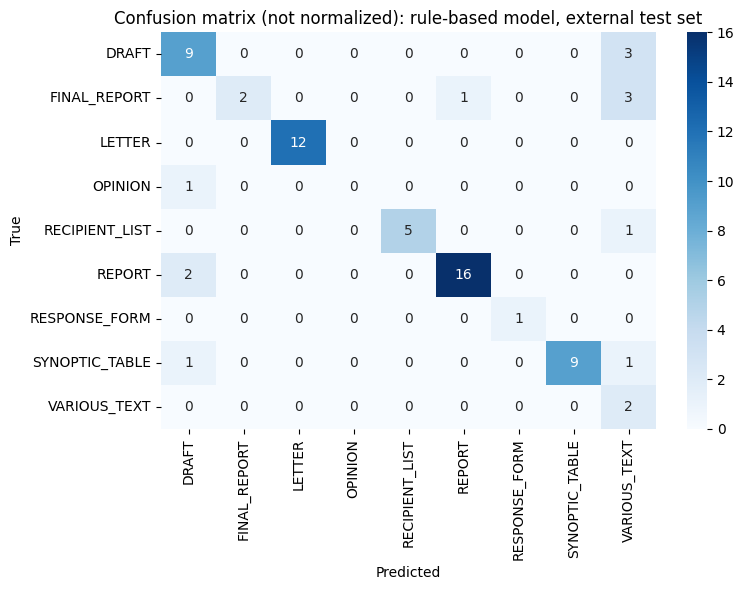

In [42]:
_df = df_test_external[df_test_external["prediction_rule"].notna()]
print(sklearn.metrics.classification_report(_df["document_type"], _df["prediction_rule"], zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _df["document_type"],
    _df["prediction_rule"],
    title="rule-based model, external test set",
    # normalize="true",
)

***

# End MLflow run

In [43]:
mlflow.end_run()

🏃 View run ambitious-cat-58 at: https://mlflow.ml1.demokratis.ch/#/experiments/2/runs/9fc11bb1c4444a1a94840aa0c7ed638f
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/2
